### Wortfrequenzanalyse_bvg_hvv_mvg.ipynb

Dieses Notebook liefert eine quantitativ-explorative Übersicht über die Wortfrequenzen zu den Verkehrsunternehmen  
Berliner Verkehrsbetriebe (BVG), Hamburger Verkehrsverbund (HVV) und Münchner Verkehrsgesellschaft (MVG).

Ziel ist es, anhand einfacher Wortfrequenzzählungen zu untersuchen, wie oft die Begriffe BVG, HVV und MVG in verschiedenen Medienquellen und Jahren vorkommen.  
Vor der eigentlichen Analyse wird die Datenherkunft überprüft, durch eine Auswertung der HTTP-Statuscodes der Originalquellen.

In der Analyse selbst werden alle Wörter aus dem gesammelten HTML-Seiteninhalt einbezogen, unabhängig vom inhaltlichen Kontext.

#### 1. Import benötigte Pakete

In [1]:
# Standard
import os # Dateipfaden
import pandas as pd # Datenanalyse
import sqlite3  # Speicherung in SQLite-Datenbanken
from datetime import datetime # Datumsangaben
from glob import glob # Mehrere Dateien suchen

# Bearbeiten von HTML-Dateien
from bs4 import BeautifulSoup  # HTML auslesen und bereinigen
from collections import Counter # Zählen

# Visualisierung
import seaborn as sns # Statistische Diagramme
import matplotlib.pyplot as plt # Diagrammerstellung 
from wordcloud import WordCloud # Wortwolken 

In [2]:
# Pfade
# Projektverzeichnis 
PROJECT_ROOT = r"D:/DBU/ADSC11 ADS-01/Studienarbeit/newspaper-scraping"

# Datei für die Analyse
DATAPATH = os.path.join(PROJECT_ROOT, "output", "wordcount_news.csv")

# Fehlersuche
INPUT_FOLDER = os.path.join(PROJECT_ROOT, "input")
DATA_LAKE = os.path.join(INPUT_FOLDER, "raw", "data-lake")
STORAGE_PATH = DATA_LAKE

# Output-Pfad
OUTPUT_FOLDER = os.path.join(PROJECT_ROOT, "output") 

#### 2. Datenexploration

##### 2.1 Datenherkunft 

In [ ]:
# Metadaten-Dateien im STORAGE_PATH suchen
metadaten_dateien = glob(os.path.join(STORAGE_PATH, "*.csv"))

# Liste für gültige DataFrames
metadaten_liste = []

# Jede Datei durchgehen
for datei in metadaten_dateien:
    dateiname = os.path.basename(datei)
    
    # Prüfen, ob Datei leer ist
    if os.path.getsize(datei) == 0:
        print(f"[INFO] Übersprungen: Leere Datei → {dateiname}")
        continue

    # Datei laden (mit Fehlermeldung, falls sie defekt ist)
    try:
        df = pd.read_csv(datei)
        metadaten_liste.append(df)
    except Exception as e:
        print(f"[WARNUNG] Fehler beim Einlesen von {dateiname}: {e}")

In [ ]:
# Gültige Dateien zusammenführen
if metadaten_liste:
    metadaten = pd.concat(metadaten_liste, ignore_index=True)
    print(f"[INFO] Erfolgreich zusammengeführt: {len(metadaten_liste)} Dateien.")
else:
    print("[WARNUNG] Keine gültigen Metadaten-Dateien gefunden.")

In [ ]:
# HTTP-Status
metadaten["status"].value_counts()

##### 2.1 Datenexploration nach der Verarbeitung

In [ ]:
# CSV-Dateien  einlesen
df_medien = pd.read_csv(DATAPATH)

In [4]:
# Anzahl Zeilen und Spalten
df_medien.shape

(48097645, 4)

In [5]:
# Spaltennamen
df_medien.columns

Index(['count', 'word', 'source', 'date'], dtype='object')

In [6]:
# Überblick Datentypen
df_medien.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48097645 entries, 0 to 48097644
Data columns (total 4 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   count   int64 
 1   word    object
 2   source  object
 3   date    object
dtypes: int64(1), object(3)
memory usage: 1.4+ GB


In [7]:
# Statistischen Merkmale für numerische Spalten 
df_medien.describe()

,count
count,4.809764e+07
mean,1.540577e+00
std,3.000133e+00
min,1.000000e+00
25%,1.000000e+00
50%,1.000000e+00
75%,1.000000e+00
max,2.470000e+02


In [8]:
# Prüfung fehlende Werte
df_medien.isnull().sum()

count        0
word      1951
source       0
date         0
dtype: int64

In [9]:
# Fehlende Wörter nach Medium
df_medien[df_medien["word"].isna()]["source"].value_counts()

source
sz              274
zeit            187
boerse          183
ntv             182
heise           148
welt            120
stern           110
tagesspiegel     92
spiegel          85
taz              84
berliner         80
faz              78
mm               71
wiwo             60
dlf              51
netzpolitik      44
handelsblatt     41
tagesschau       31
abendblatt       18
dw-de             8
pioneer           4
Name: count, dtype: int64

In [10]:
# Neue Spalte Jahr
df_medien["date"] = pd.to_datetime(df_medien["date"])  
df_medien["jahr"] = df_medien["date"].dt.year.astype(int)  # Jahre als ganze Zahlen anzeigen

In [11]:
# Prüfung
df_medien.columns

Index(['count', 'word', 'source', 'date', 'jahr'], dtype='object')

In [12]:
# Fehlende Wörter nach Jahr 
df_medien[df_medien["word"].isna()]["jahr"].value_counts().sort_index()

jahr
2021    561
2022    546
2023    268
2024    376
2025    200
Name: count, dtype: int64

In [22]:
df_medien[df_medien["word"].isna()].sample(5)

,count,word,source,date,jahr
25889708,1,NaN,taz,2024-03-09,2024
13137177,1,NaN,taz,2021-08-18,2021
26815039,1,NaN,zeit,2024-05-19,2024
19678915,2,NaN,zeit,2022-12-04,2022
15904519,1,NaN,welt,2022-03-08,2022


In [15]:
# Fehlende Werte löschen, weil sie keine Infos enthalten
df_medien = df_medien[df_medien["word"].notna()]

#### 3. Wortfrequenzanalyse

In [17]:
# Neuer DataFrame für Filter
df_oepnv = df_medien.copy()

##### 3.1 Häufigkeit der exakten Begriffe BVG, HVV und MVG

In [ ]:
# Häufigkeit der Begriffe BVG, MVG, HVV in den ausgewählten Medien
# Filter Begriffe
treffer = df_oepnv[df_oepnv["word"].isin(["bvg", "mvg", "hvv"])]

# Absolute Häufigkeiten
wert_counts = treffer["word"].value_counts()

# in % 
wert_prozent = wert_counts / wert_counts.sum() * 100

# Ergebnis anzeigen
print("Anzahl der Begriffe BVG, MVG, HVV:")
print(df_oepnv[df_oepnv["word"].isin(["bvg", "mvg", "hvv"])]["word"].value_counts())
print("Anteil der Begriffe BVG, MVG, HVV in %:")
print(wert_prozent.round(2)) # mit 2 Dezimalstellen

Anzahl der Begriffe BVG, MVG, HVV:
word
bvg    1362
hvv     564
mvg     125
Name: count, dtype: int64
Anteil der Begriffe BVG, MVG, HVV in %:
word
bvg    66.41
hvv    27.50
mvg     6.09
Name: count, dtype: float64


In [ ]:
# Häufigkeit der Begriffe BVG, MVG, HVV nach Jahren
# Gruppierung: Nennungen je Jahr und Begriff summieren
oepnv_jahre = treffer.groupby(["year", "word"])["count"].sum().unstack().fillna(0).astype(int)

# Anzeigen
print(oepnv_jahre)

word  bvg  hvv  mvg
year               
2021  485   35   41
2022  497  407   65
2023  343  165   16
2024  513  165   17
2025  300   35    2


In [40]:
# Häufigkeit der Begriffe BVG, MVG, HVV nach Jahren exportieren
oepnv_jahre.to_csv(os.path.join(OUTPUT_FOLDER, "oepnv_nennungen_pro_jahr.csv"))

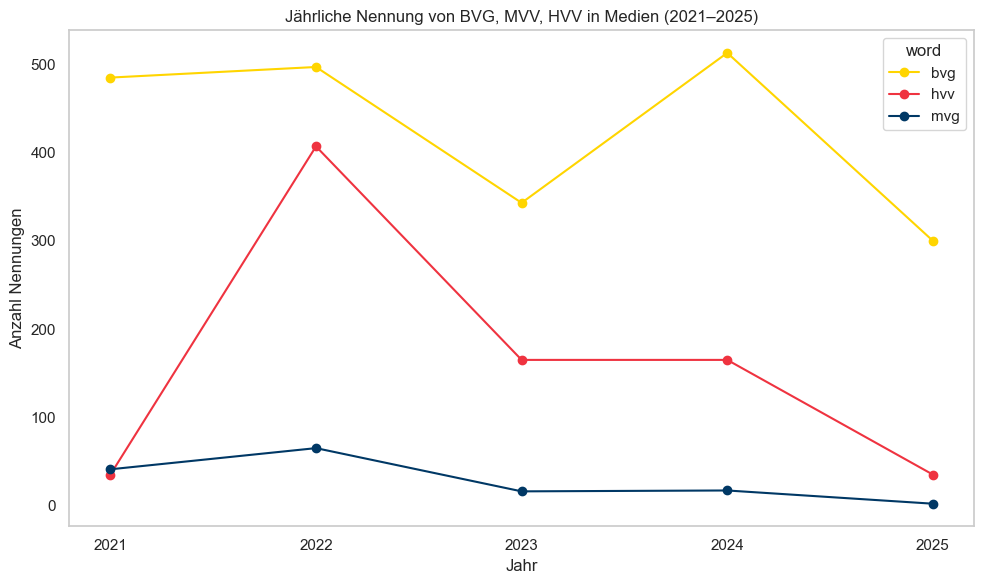

In [ ]:
# Plot: Liniendiagramm Häufigkeit der Begriffe BVG, MVG, HVV nach Jahren
# Vorbereitung
# Farbdefinitionen nach CI der Verkerhsunternehmen
bvg_color = "#FFD500"   # BVG-Gelb
mvv_color = "#003865"   # MVV-Blau
hvv_color = "#EF3340"   # HVV-Rot

# Dictionary für die CI-Farben
farben = {
    "bvg": bvg_color,
    "mvg": mvv_color,
    "hvv": hvv_color
}

# Kombination Verkehrsunternehmen und Jahr
ax = oepnv_jahre.plot(
    kind="line",
    marker="o",
    figsize=(10, 6),
    color=[farben[col] for col in oepnv_jahre.columns]  # Farbenzuteilung pro Spalte
)

# Plot Formatierung: Titel, Achsen, Layout 
plt.title("Jährliche Nennung von BVG, MVV, HVV in Medien (2021–2025)")
plt.ylabel("Anzahl Nennungen")
plt.xlabel("Jahr")
plt.grid(False)
plt.xticks(ticks=oepnv_jahre.index, labels=oepnv_jahre.index.astype(int)) 
plt.tight_layout()
plt.show()

In [48]:
# Bild exportieren
plt.savefig(os.path.join(OUTPUT_FOLDER, "plot_oepnv_nennungen_pro_jahr.png"), dpi=300, bbox_inches="tight")

<Figure size 640x480 with 0 Axes>

In [ ]:
# Häufigkeit der Begriffe BVG, MVG, HVV nach Medien
# Gruppierung: Häufigkeit der Begriffe je Medium und Begriff summieren
oepnv_quellen = treffer.groupby(["source", "word"])["count"].sum().unstack().fillna(0).astype(int)
# in %
oepnv_quellen_prozent = oepnv_quellen.div(oepnv_quellen.sum(axis=1), axis=0) * 100

# Anzeigen
print(oepnv_quellen.sort_index())
print(oepnv_quellen_prozent.round(2).sort_index()) # 2 Kommastellen

word           bvg  hvv  mvg
source                      
abendblatt       2  796    0
berliner       742    0    0
boerse           0    0  116
dlf              1    0    0
faz              4    0    0
heise            7    0    0
mm               8    0    0
ntv             16    3    1
spiegel          9    0    0
stern            7    2    0
sz               4    1   23
t3n              6    0    0
tagesspiegel  1217    0    0
taz             94    0    0
welt            11    1    1
zeit            10    4    0
word             bvg    hvv     mvg
source                             
abendblatt      0.25  99.75    0.00
berliner      100.00   0.00    0.00
boerse          0.00   0.00  100.00
dlf           100.00   0.00    0.00
faz           100.00   0.00    0.00
heise         100.00   0.00    0.00
mm            100.00   0.00    0.00
ntv            80.00  15.00    5.00
spiegel       100.00   0.00    0.00
stern          77.78  22.22    0.00
sz             14.29   3.57   82.14
t3n       

In [ ]:
# Häufigkeit der Begriffe BVG, MVG, HVV nach Medien und Jahren
# Pivot-Tabelle für bessere Lesbarkeit
for wort in ["bvg", "mvg", "hvv"]:
    df_tmp = treffer[treffer["word"] == wort]
    pivot = df_tmp.pivot_table(index="year", columns="source", values="count", aggfunc="sum", fill_value=0)
    print(f"\nPivot-Tabelle für {wort.upper()}:")
    display(pivot)


Pivot-Tabelle für BVG:


source,abendblatt,berliner,dlf,faz,heise,mm,ntv,spiegel,stern,sz,t3n,tagesspiegel,taz,welt,zeit
year,,,,,,,,,,,,,,,
2021,0,70,0,0,1,0,0,0,3,0,0,404,7,0,0
2022,0,69,0,2,0,0,1,5,1,0,0,410,7,1,1
2023,2,160,0,0,1,8,0,0,0,1,6,138,27,0,0
2024,0,288,0,0,3,0,4,2,2,2,0,174,31,5,2
2025,0,155,1,2,2,0,11,2,1,1,0,91,22,5,7



Pivot-Tabelle für MVG:


source,boerse,ntv,sz,welt
year,,,,
2021,37,0,3,1
2022,60,0,5,0
2023,4,0,12,0
2024,15,0,2,0
2025,0,1,1,0



Pivot-Tabelle für HVV:


source,abendblatt,ntv,stern,sz,welt,zeit
year,,,,,,
2021,33,2,0,0,0,0
2022,403,0,0,0,0,4
2023,164,0,1,0,0,0
2024,161,1,1,1,1,0
2025,35,0,0,0,0,0


In [41]:
# Pivot mit Häufigkeit der Begriffe BVG, MVG, HVV nach Medien und Jahren exportieren
for wort in ["bvg", "mvg", "hvv"]:
    df_tmp = treffer[treffer["word"] == wort]
    pivot = df_tmp.pivot_table(index="year", columns="source", values="count", aggfunc="sum", fill_value=0)

    # Export
    filename = f"oepnv_nennungen_medium_pro_jahr_{wort}.csv"
    pivot.to_csv(os.path.join(OUTPUT_FOLDER, filename))

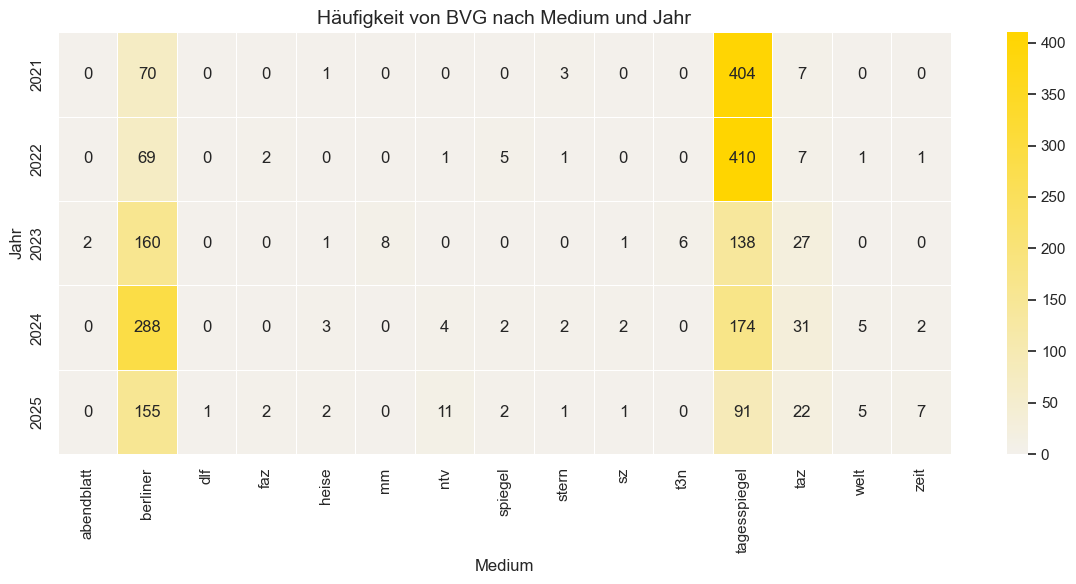

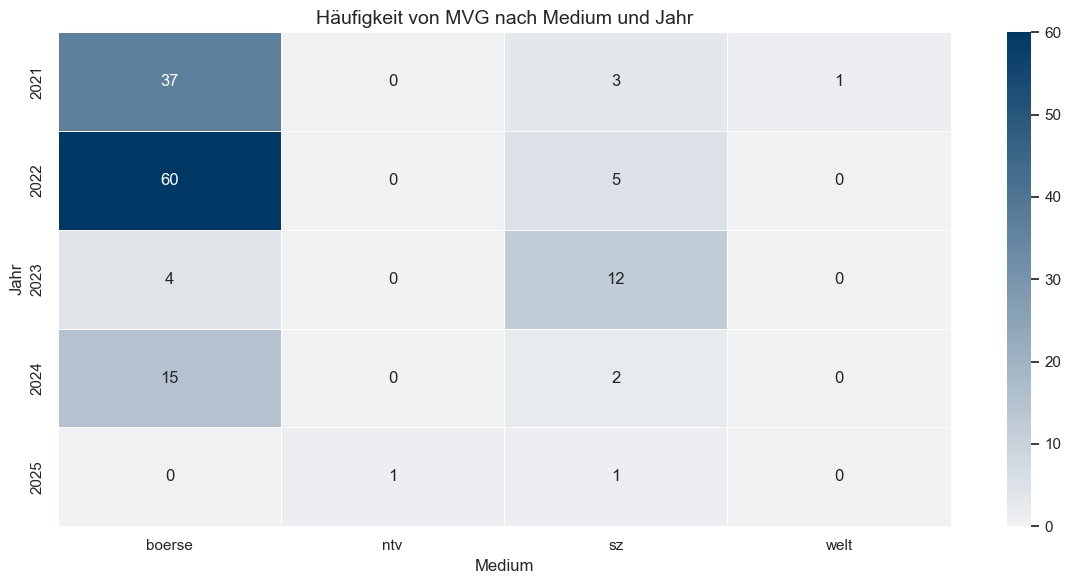

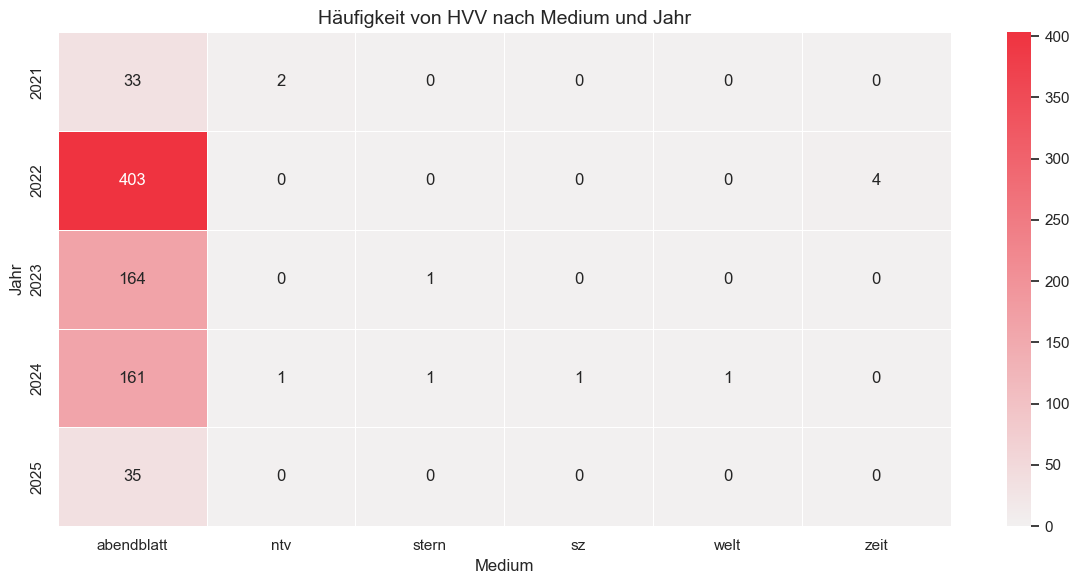

In [ ]:
# Plot: Heatmap Häufigkeit der Begriffe BVG, MVG, HVV nach Medien und Jahren
# Vorbereitung
sns.set_theme(style="whitegrid")

# Schleife über die Verkehrsunternehmen
for wort in ["bvg", "mvg", "hvv"]:
    # Filtern
    df_tmp = treffer[treffer["word"] == wort]

    # Pivot-Tabelle: Zeilen = Jahr, Spalten = Medium
    pivot = df_tmp.pivot_table(index="year", columns="source", values="count", aggfunc="sum", fill_value=0)

    # Heatmap zeichnen
    plt.figure(figsize=(12, 6))
    cmap_farbe = farben.get(wort, "gray")

    # Farbschema auf Basis einer Einzelfarbe
    sns.heatmap(pivot, cmap=sns.light_palette(cmap_farbe, as_cmap=True), annot=True, fmt="d", linewidths=0.5)

    # Plot Formatierung: Titel, Achsen, Layout 
    plt.title(f"Häufigkeit von {wort.upper()} nach Medium und Jahr", fontsize=14)
    plt.xlabel("Medium")
    plt.ylabel("Jahr")
    plt.tight_layout()
    plt.show()

In [ ]:
# Häufigkeit der Begriffe BVG, MVG, HVV nach Medien-Clustern
# Vorbereitung
# Dictionary für Analyse nach Clustern
cluster_map = {
    # Öffentlich-rechtlich
    "dlf": "Öffentlich-rechtlich",
    "tagesschau": "Öffentlich-rechtlich",

    # Wirtschaftsmedien
    "handelsblatt": "Wirtschaft",
    "wiwo": "Wirtschaft",
    "mm": "Wirtschaft",
    "boerse": "Wirtschaft",

    # Große Medien
    "sz": "Große Medien",
    "zeit": "Große Medien",
    "faz": "Große Medien",
    "taz": "Große Medien",
    "welt": "Große Medien",
    "spiegel": "Große Medien",
    "stern": "Große Medien",

    # Regionale Medien
    "abendblatt": "Regional",
    "berliner": "Regional",
    "tagesspiegel": "Regional",

    # Digitale Nachrichtenportale
    "ntv": "Digital",
    "pioneer": "Digital",
    "dw-de": "Digital",

    # Technologie
    "heise": "Technologie",
    "golem": "Technologie",
    "netzpolitik": "Technologie",
    "t3n": "Technologie"
}

In [30]:
# Häufigkeit der Begriffe BVG, MVG, HVV nach Medien-Clustern
# Medien-Cluster zuordnen
treffer["cluster"] = treffer["source"].map(cluster_map)
# Kopie nach SettingWithCopyWarning
treffer = treffer.copy()

In [ ]:
# Cluster-Spalte zuordnen
treffer["cluster"] = treffer["source"].map(cluster_map)

# Pivot-Tabelle nach Jahr und Cluster
pivot_cluster = treffer.groupby(["year", "cluster", "word"])["count"] \
    .sum().unstack().fillna(0).astype(int)

# Anzeigen
display(pivot_cluster)

word                       bvg  hvv  mvg
year cluster                            
2021 Digital                 0    2    0
     Große Medien           10    0    4
     Regional              474   33    0
     Technologie             1    0    0
     Wirtschaft              0    0   37
2022 Digital                 1    0    0
     Große Medien           17    4    5
     Regional              479  403    0
     Wirtschaft              0    0   60
2023 Große Medien           28    1   12
     Regional              300  164    0
     Technologie             7    0    0
     Wirtschaft              8    0    4
2024 Digital                 4    1    0
     Große Medien           44    3    2
     Regional              462  161    0
     Technologie             3    0    0
     Wirtschaft              0    0   15
2025 Digital                11    0    1
     Große Medien           40    0    1
     Regional              246   35    0
     Technologie             2    0    0
     Öffentlich-rechtlich    1    0    0

In [42]:
# Pivot mit Häufigkeit der Begriffe BVG, MVG, HVV nach Medien-Clustern und Jahren exportieren
pivot_cluster.to_csv(os.path.join(OUTPUT_FOLDER, "oepnv_nennungen_cluster_pro_jahr.csv"))

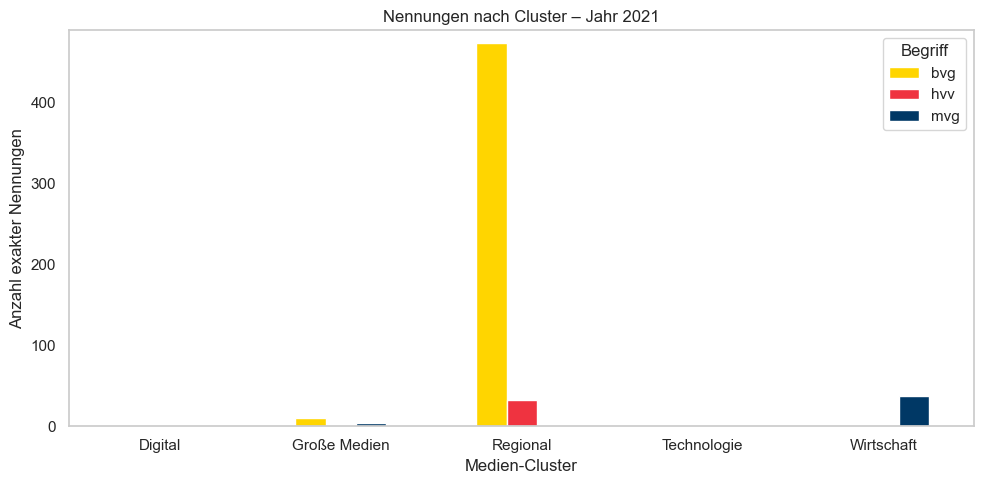

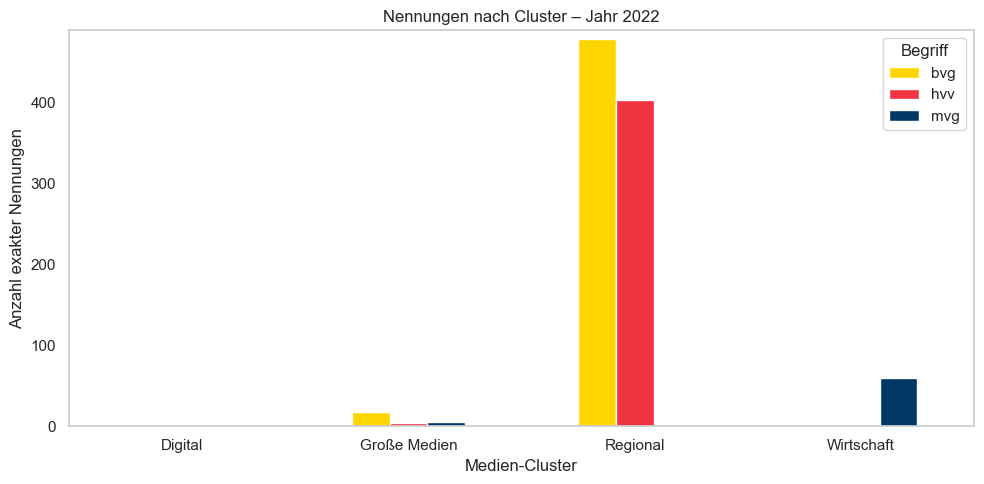

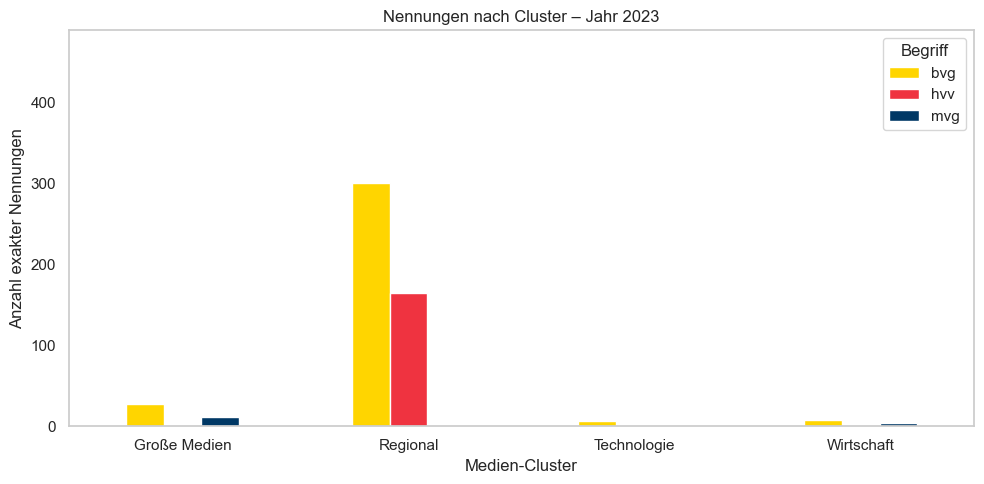

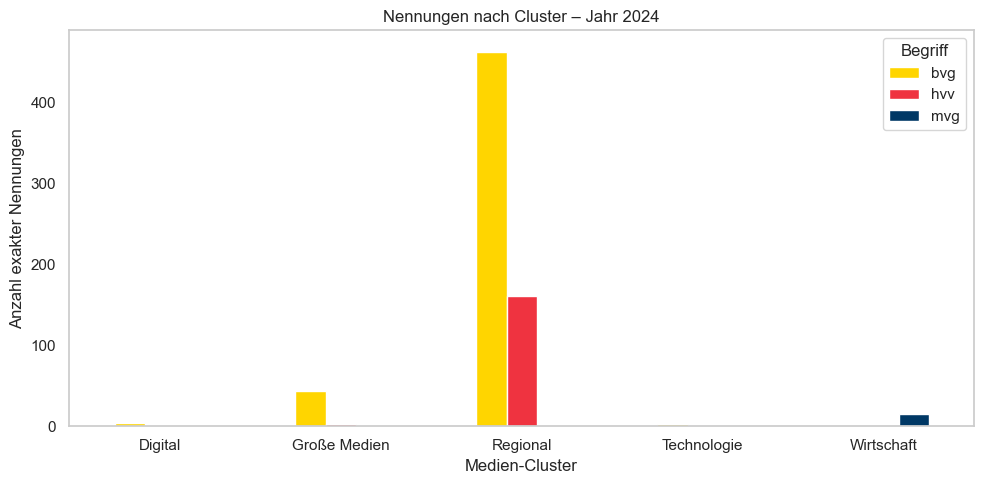

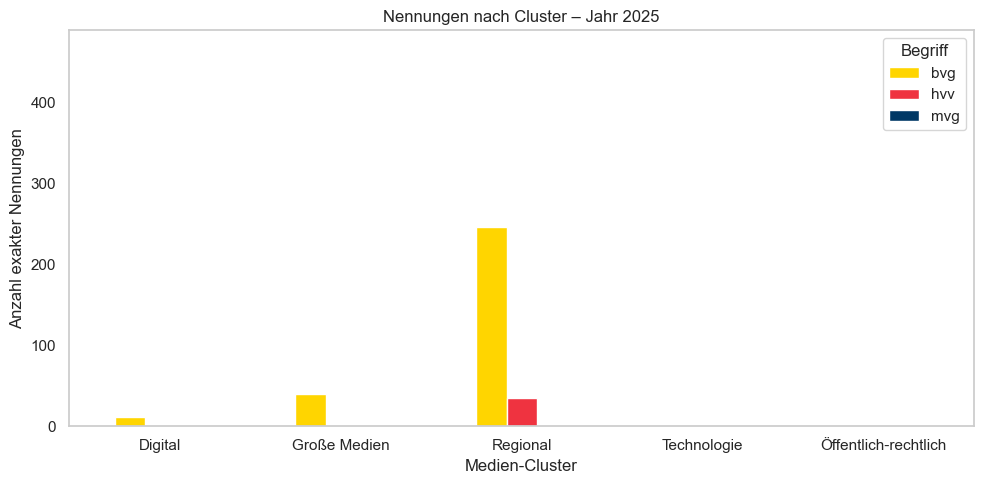

In [ ]:
# Plot: Gruppiertes Balkendiagramm Häufigkeit der Begriffe BVG, MVG, HVV nach Medien-Clustern und Jahren
# Vorbereitung
# Liste aller Jahre im Datensatz
jahre = pivot_cluster.index.get_level_values("year").unique()

# Gleiche Skalierung für alle Balkendiagramme
# Maximalwert über alle Jahre & Begriffe
max_wert = pivot_cluster.max().max()

# Für jedes Jahr Balkendiagramm nach Medien-Clustern und Begriffen erzeugen
for year in jahre:
    df_plot = pivot_cluster.loc[year]

    # Gruppiertes Balkendiagramm
    ax = df_plot.plot(
        kind="bar",
        figsize=(10, 5),
        color=[farben.get(k, "gray") for k in df_plot.columns]
    )

    # Plot Formatierung: Titel, Achsen, Layout 
    plt.title(f"Nennungen nach Cluster – Jahr {year}")
    plt.ylabel("Anzahl exakter Nennungen")
    plt.xlabel("Medien-Cluster")
    plt.xticks(rotation=0)  # Beschriftung horizontal
    plt.ylim(0, max_wert + 10) # Skalierung mit Puffer
    plt.legend(title="Begriff")
    plt.tight_layout()
    plt.grid(False)
    plt.show()

##### 3.2 Wortformen mit den Begriffen BVG, HVV und MVG  

In [33]:
# Wortformen, die BVG, MVG oder HVV beinhalten 
df_oepnv = df_medien[df_medien["word"].str.contains("bvg|mvg|hvv", na=False)]
print("Häufigkeit der Wortformen BVG, MVG, HVV:")
print(df_oepnv["word"].value_counts())

Häufigkeit der Wortformen BVG, MVG, HVV:
word
bvg                  1362
hvv                   564
bvg:                  219
mvg                   125
bvg-bus                80
                     ... 
bvg-busknoten.          1
bvg-knoten              1
bvg-wartehäuschen       1
bvg-mitarbeitern.       1
bvg-vorständin          1
Name: count, Length: 276, dtype: int64


In [44]:
# Häufigkeit der Wortformen exportieren
word_counts = df_oepnv["word"].value_counts()
word_counts.to_csv(os.path.join(OUTPUT_FOLDER, "oepnv_wortformen_haeufigkeit.csv"))

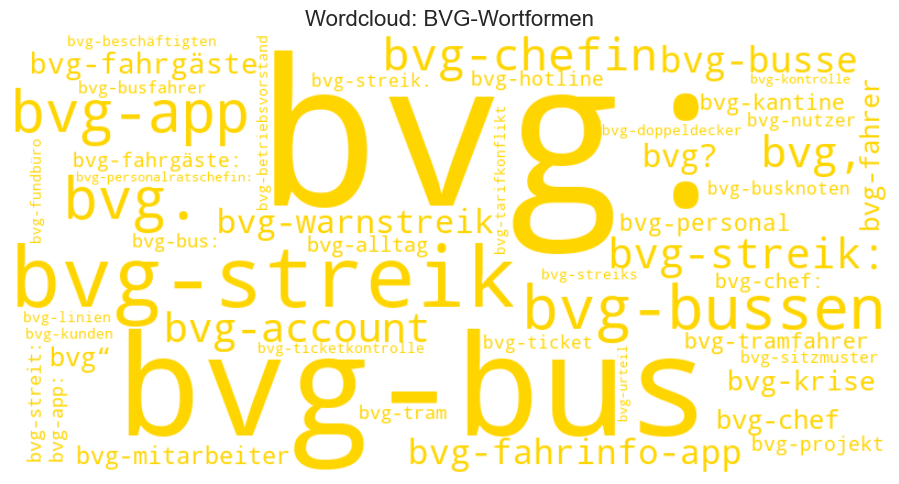

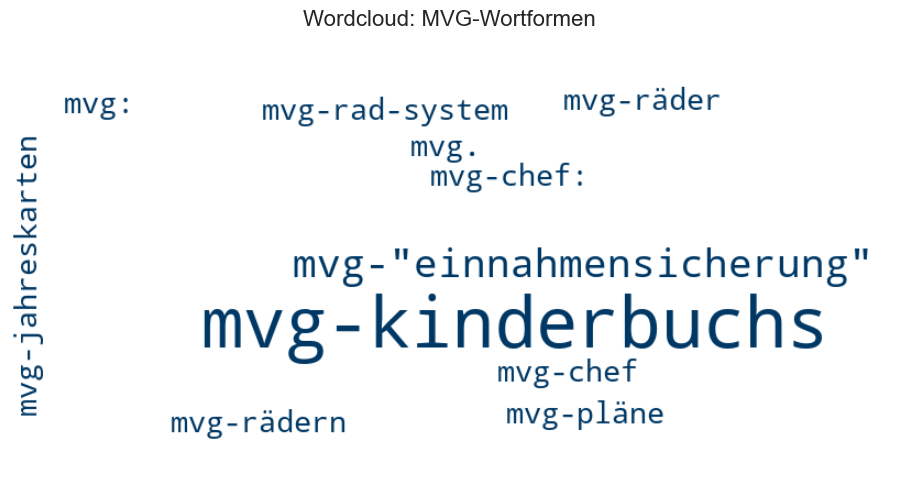

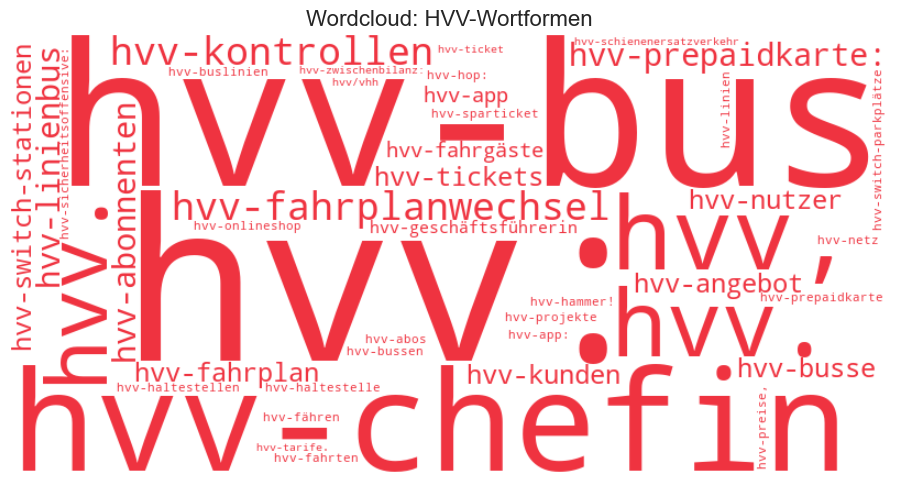

In [ ]:
# Plot: Wordclouds für Wortformen, die mit BVG, MVG oder HVV beginnen (alle Jahre zusammengefasst)
# Vorbereitung
# Begriffsliste
begriffsliste = ["bvg", "mvg", "hvv"]

# Für jeden Begriff eine Wordcloud generieren
for begriff in begriffsliste:
    # Filter: alle Wörter, die mit BVG-, MVG- oder HVV- beginnen 
    # exakte Begriffe ausschließen
    df_wortformen = df_medien[
        (df_medien["word"].str.startswith(begriff, na=False)) & 
        (df_medien["word"] != begriff)
    ]

    # Häufigkeit je Wortform summieren
    wortformen = df_wortformen.groupby("word")["count"].sum().sort_values(ascending=False).head(50)
    # für Wordcloud in Dictionary umwandeln
    wort_dict = wortformen.to_dict()

    # CI-Farben 
    farbe = farben.get(begriff, "#000000")

    # Wordcloud erzeugen 
    wordcloud = WordCloud(
        width=800, height=400,
        background_color="white",
        color_func=lambda *args, **kwargs: farbe
    ).generate_from_frequencies(wort_dict)

    # Plot Formatierung: Titel, Achsen, Layout  
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Wordcloud: {begriff.upper()}-Wortformen", fontsize=16)
    plt.tight_layout()
    plt.show()

In [47]:
# Bilder exportieren
dateiname = f"wordcloud_{begriff}.png"
plt.savefig(os.path.join(OUTPUT_FOLDER, dateiname), dpi=300, bbox_inches="tight")
plt.close()

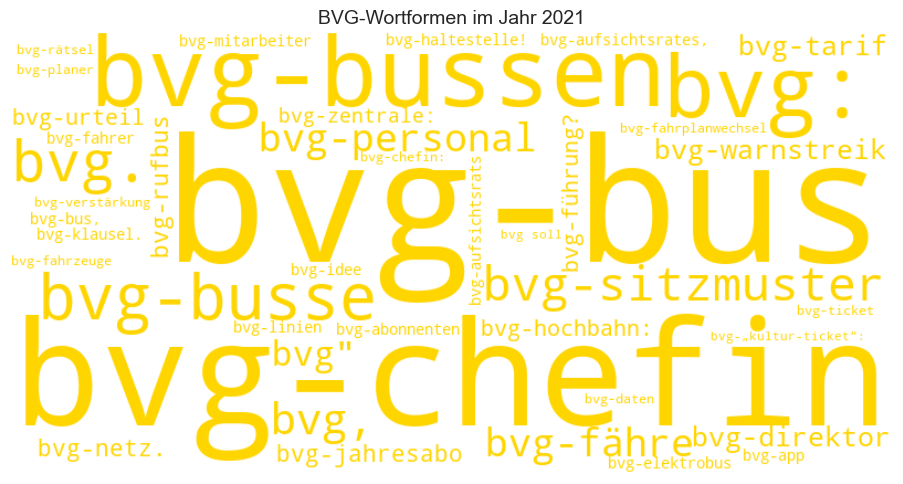

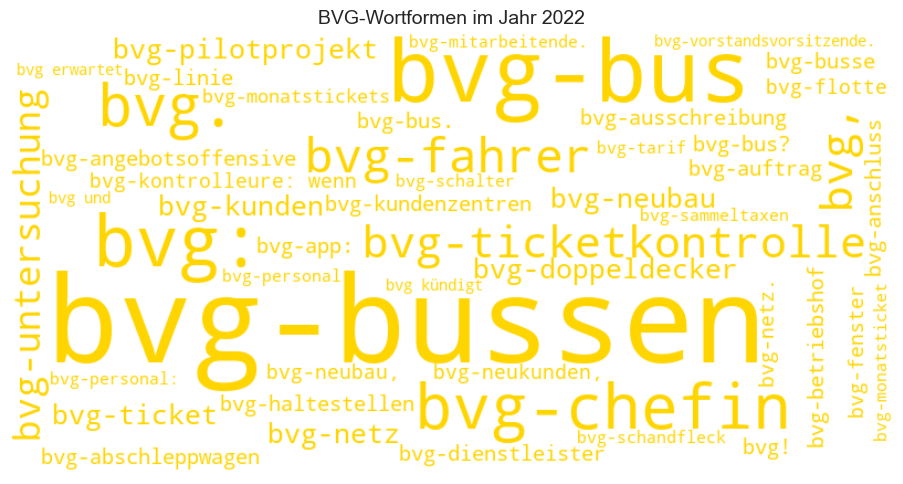

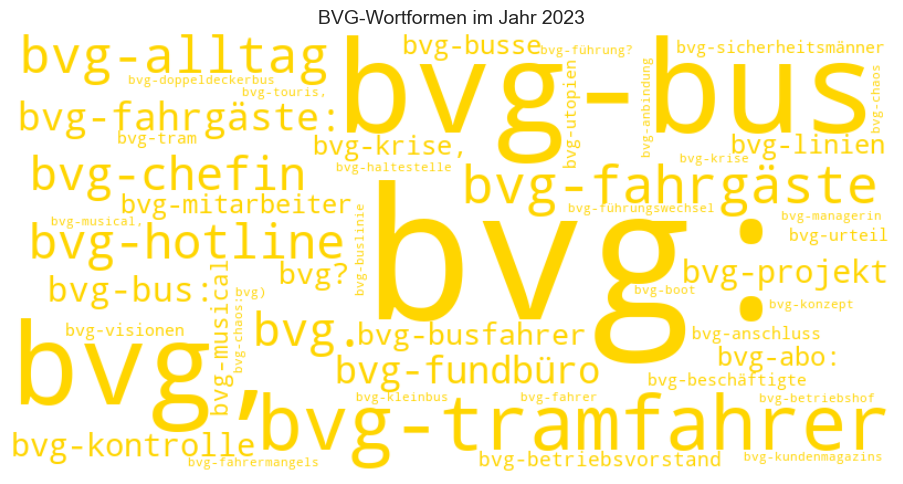

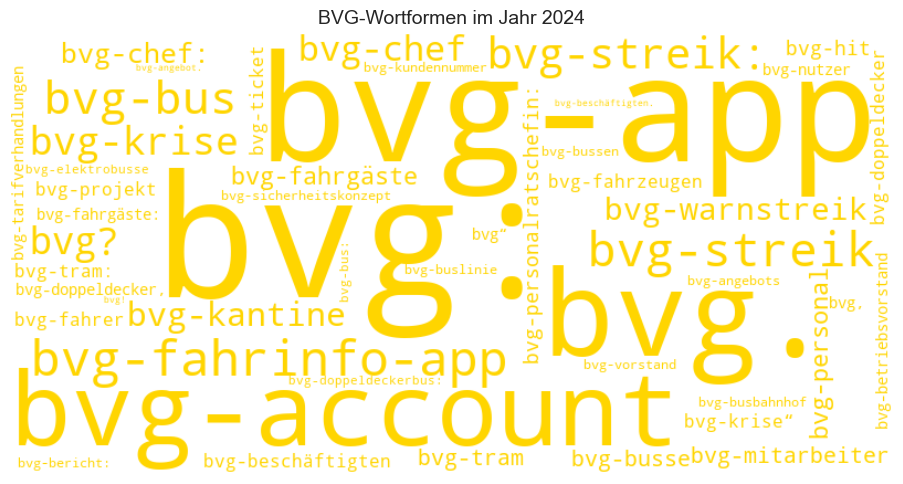

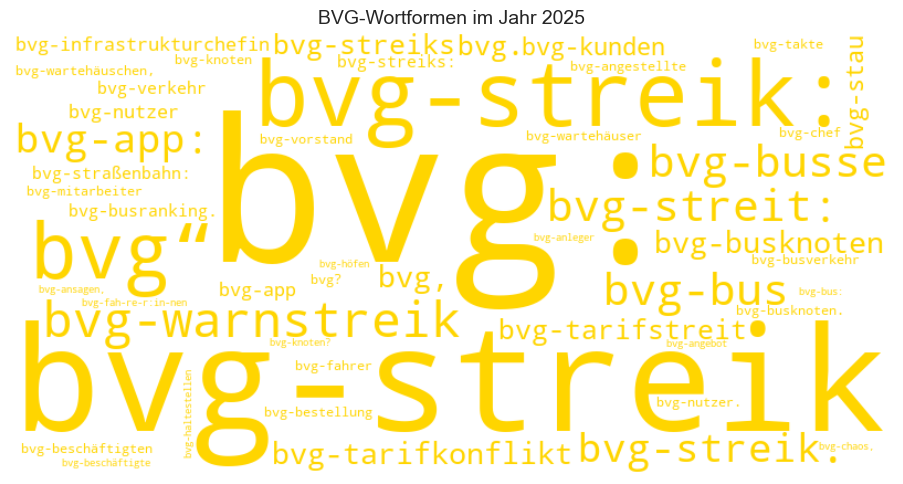

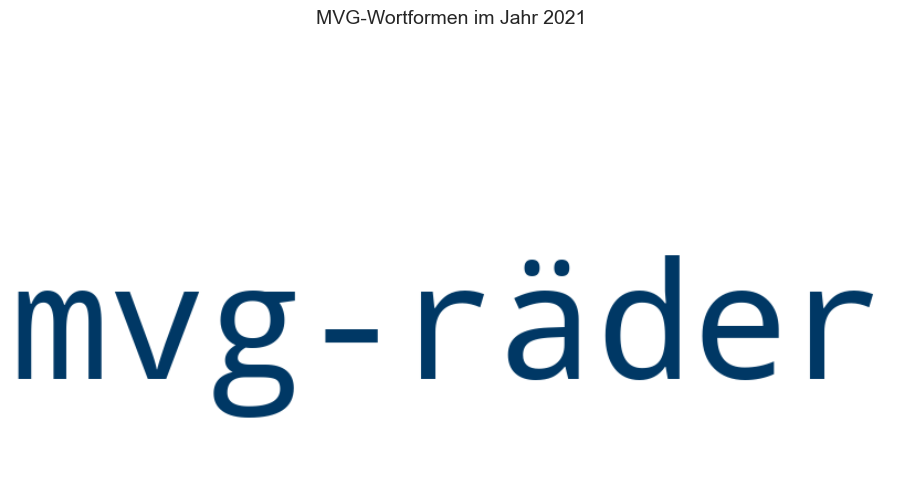

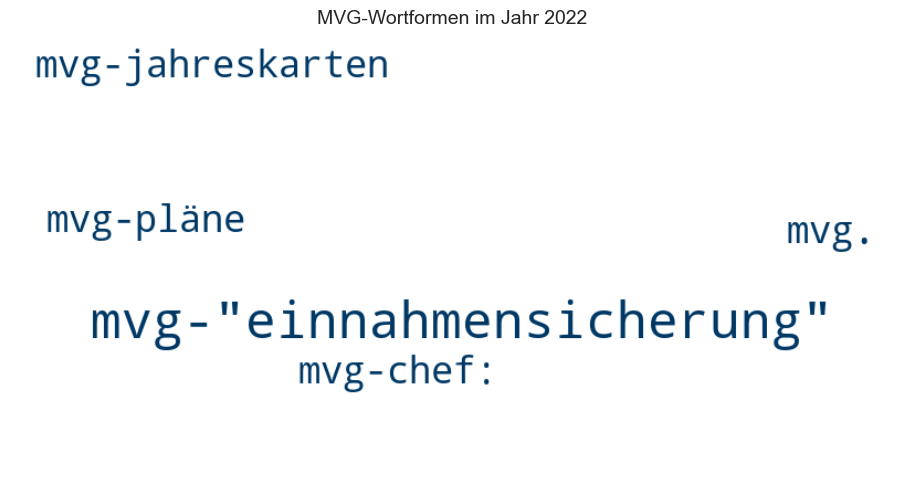

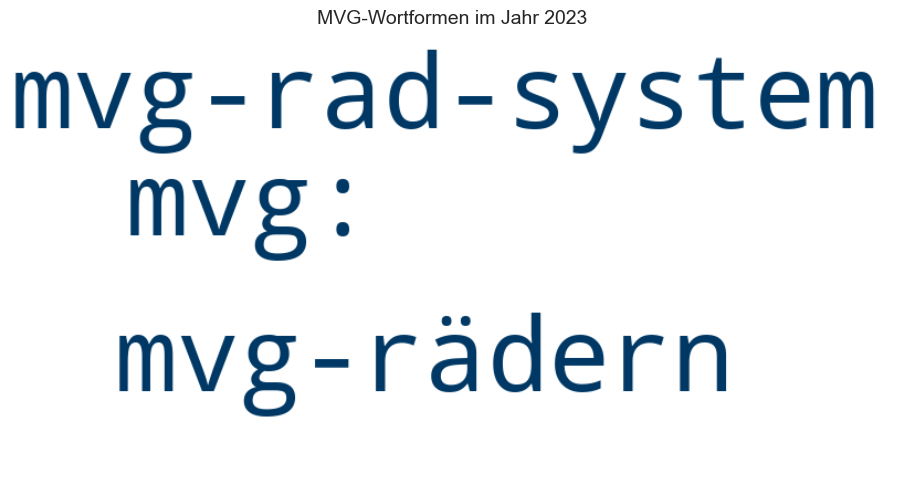

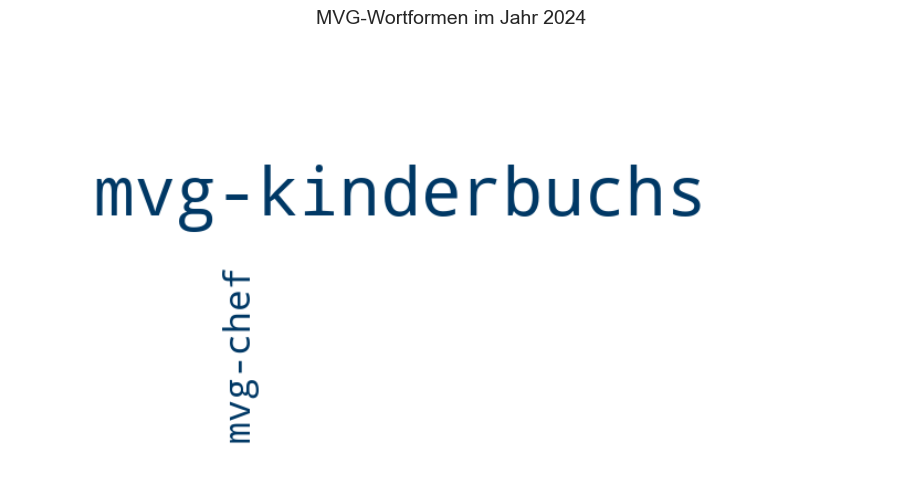

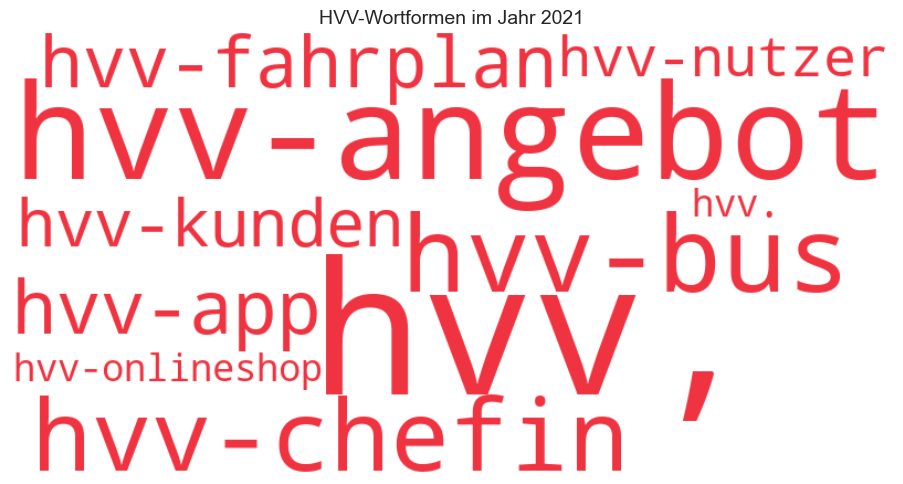

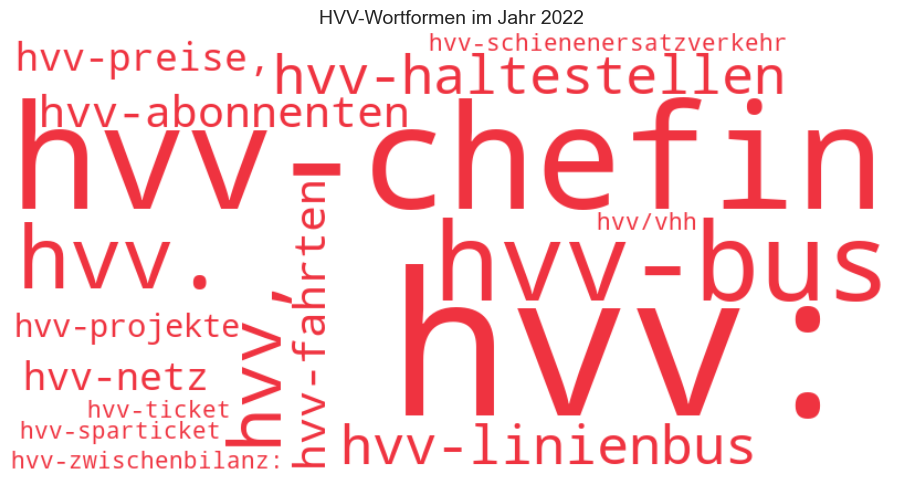

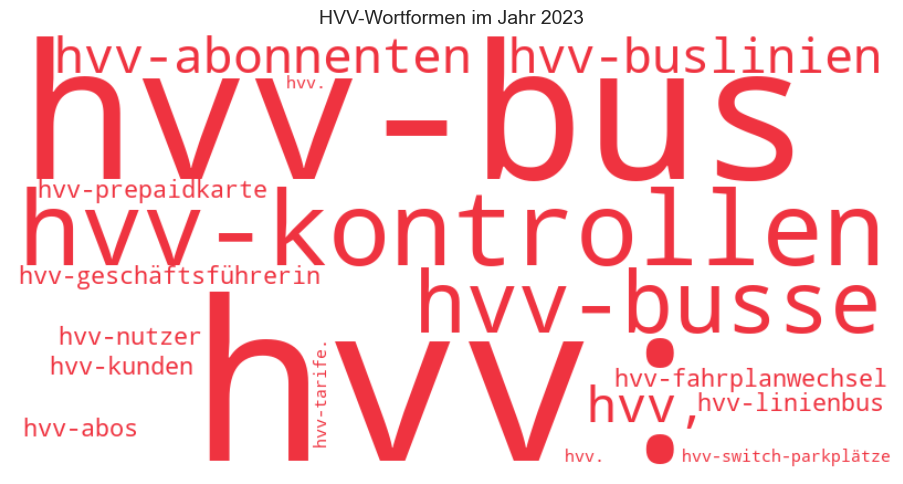

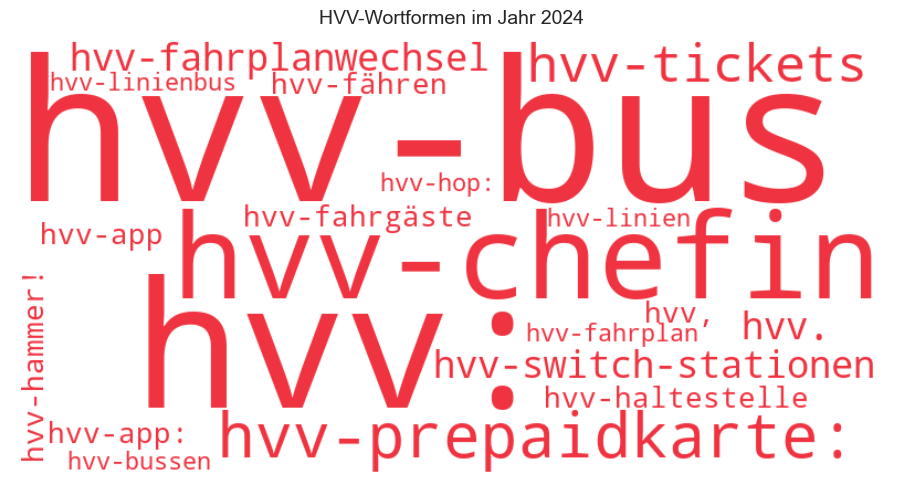

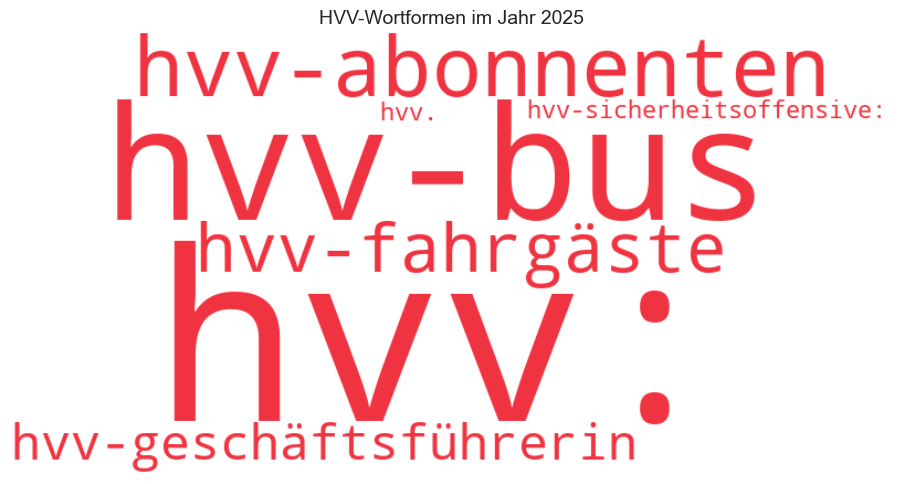

In [ ]:
# Plot: Wordclouds für Wortformen, die mit BVG, MVG oder HVV beginnen pro Jahr
# Vorbereitung
# Liste der Jahre
jahre = sorted(df_medien["year"].dropna().unique().astype(int))

# Schleife über Begriffe und Jahre
for begriff in begriffsliste:
    for jahr in jahre:
        # Filter: Wortformen, die mit dem Begriff beginnen (aber nicht exakt der Begriff sind)
        df_wortformen = df_medien[
            (df_medien["word"].str.startswith(begriff, na=False)) &
            (df_medien["word"] != begriff) &
            (df_medien["year"] == jahr)
        ]

        # Wenn es keine Daten gibt, nächsten Jahrgang überspringen
        if df_wortformen.empty:
            continue

        # Häufigkeit der Wortformen berechnen
        wortformen = df_wortformen.groupby("word")["count"].sum().sort_values(ascending=False).head(50)
        wort_dict = wortformen.to_dict()

        # Wordcloud erzeugen
        farbe = farben.get(begriff, "#000000")
        wordcloud = WordCloud(
            width=800,
            height=400,
            background_color="white",
            color_func=lambda *args, **kwargs: farbe
        ).generate_from_frequencies(wort_dict)

        # Plot Formatierung: Titel, Achsen, Layout 
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.title(f"{begriff.upper()}-Wortformen im Jahr {jahr}", fontsize=14)
        # Anzahl Wortformen anzeigen
        print(f"{begriff.upper()} {int(jahr)}: {len(wortformen)} Wortformen gefunden.")
        plt.tight_layout()
        plt.show()